In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import warnings

warnings.filterwarnings("ignore")

# Data preprocessing

## Cropped face

In [62]:
face_cascade = cv2.CascadeClassifier('opencv/haarcascade_frontalface_default.xml')
eyes_cascade = cv2.CascadeClassifier('opencv/haarcascade_eye.xml')

def get_cropped_face(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x, y, w, h) in faces:
        roi_color = img[y:y+h, x:x+w]
        roi_gray = img[y:y+h, x:x+w]
        eyes = eyes_cascade.detectMultiScale(roi_gray, 1.3, 5)
        if len(eyes) >= 2:
            return roi_color

## Creating folders

In [63]:
import os
import shutil
curr_path = "./dataset/"
to_path = "./dataset/cropped/"

img_dirs = []

for entry in os.scandir(curr_path):
    if entry.is_dir():
        img_dirs.append(entry.path)

if os.path.exists(to_path):
    shutil.rmtree(to_path)
os.mkdir(to_path)    

In [64]:
img_dirs

['./dataset/adrian_von_ziegler',
 './dataset/fatma_turgut',
 './dataset/jeff_danna',
 './dataset/michael_rhein',
 './dataset/sarah_jane_scott']

In [65]:
img_dirs

['./dataset/adrian_von_ziegler',
 './dataset/fatma_turgut',
 './dataset/jeff_danna',
 './dataset/michael_rhein',
 './dataset/sarah_jane_scott']

In [66]:
singer_names_dict = {}
for img_dir in img_dirs:
    singer_name = img_dir.split("/")[-1]
    singer_names_dict[singer_name] = []
    count = 1
    print(f"{singer_name} cropped directory is loading")
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_face(entry.path)
        if roi_color is not None:
            cropped_folder = to_path + singer_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
            file_name = singer_name + str(count) + ".jpg"
            file_path = cropped_folder + "/" + file_name
            singer_names_dict[singer_name].append(file_path)
            cv2.imwrite(file_path, roi_color)
            count += 1

adrian_von_ziegler cropped directory is loading
fatma_turgut cropped directory is loading
jeff_danna cropped directory is loading
michael_rhein cropped directory is loading
sarah_jane_scott cropped directory is loading


# Feature engineering

In [67]:
import pywt
def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)   
    imArray /= 255
    
    coeffs = pywt.wavedec2(imArray, wavelet=mode, level=level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    imArray_H = pywt.waverec2(coeffs_H, wavelet=mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)

    return imArray_H

In [68]:
class_dict = {
    'adrian_von_ziegler':0,
    'fatma_turgut':1,
    'jeff_danna':2,
    'michael_rhein':3,
    'sarah_jane_scott':4
}

In [69]:
X = []
y = []

for singer_name, image_files in singer_names_dict.items():
    for image in image_files:
        img = cv2.imread(image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img, 'haar', 5)
        scalled_har_img = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3, 1), scalled_har_img.reshape(32*32, 1)))
        X.append(combined_img)
        y.append(class_dict[singer_name])

In [70]:
32*32*3 + 32*32

4096

In [71]:
X = np.array(X).reshape(len(X), 4096).astype(float)
X

array([[ 18.,  27.,  36., ..., 240.,  24.,  15.],
       [ 68.,  51.,  23., ...,   3.,  17., 253.],
       [ 55.,  61.,  61., ..., 236.,  15.,  10.],
       ...,
       [ 58., 101., 156., ..., 246.,   4., 177.],
       [ 65., 106., 151., ..., 191.,  11.,  24.],
       [137., 164., 174., ...,  16.,  20., 142.]])

In [72]:
X.shape

(64, 4096)

# Machine Learning

In [73]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.1)

In [75]:
pipe = Pipeline([('scaler', StandardScaler()),('svc', SVC(kernel="linear", C=1))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.5714285714285714

In [76]:
param_grid = {
    'svc': {
        'model': SVC(),
        'params': {
            'svc__C': [1, 10, 20, 30],
            'svc__kernel': ["rbf", "linear"]
        }
    },
    'lr': {
        'model': LogisticRegression(),
        'params': {
            'logisticregression__C': [1, 10, 20, 30]
        }
        
    },
    'rf': {
        'model': RandomForestClassifier(),
        'params': {
            "randomforestclassifier__n_estimators": [10, 100, 250, 500, 750, 1000]
        }
    }
}

In [77]:
scores = []
for k, v in param_grid.items():
    pipe = make_pipeline(StandardScaler(), v["model"])
    clf = GridSearchCV(pipe, v["params"], cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        "model": k,
        "best_param": clf.best_params_,
        "best_score": clf.best_score_
    })

In [78]:
import pandas as pd
df = pd.DataFrame(scores)
df

,model,best_param,best_score
0,svc,"{'svc__C': 10, 'svc__kernel': 'rbf'}",0.772727
1,lr,{'logisticregression__C': 1},0.719697
2,rf,{'randomforestclassifier__n_estimators': 250},0.756061


In [79]:
svc = SVC(C=10)
svc.fit(X_train, y_train)
svc.score(X_test, y_test)

0.7142857142857143

In [82]:
from sklearn.metrics import confusion_matrix, classification_report
pred = svc.predict(X_test)
cm = confusion_matrix(y_test, pred)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           2       0.67      1.00      0.80         2
           3       0.00      0.00      0.00         2
           4       0.75      1.00      0.86         3

    accuracy                           0.71         7
   macro avg       0.47      0.67      0.55         7
weighted avg       0.51      0.71      0.60         7



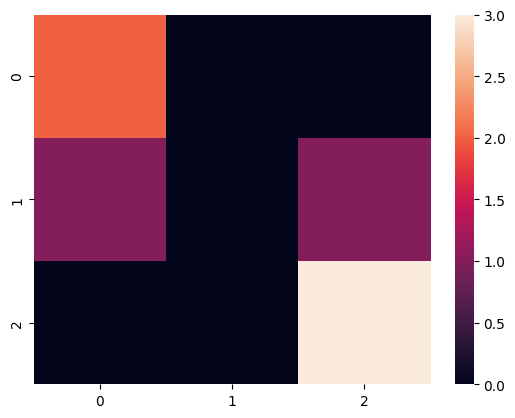

In [85]:
sns.heatmap(cm)
plt.draw()

# Save model and columns

In [86]:
import joblib
joblib.dump(svc, "saved_model.pkl")

['saved_model.pkl']

In [88]:
import json
with open("class_dictionary.json", "w") as f:
    f.write(json.dumps(class_dict))